# Pràctica 2: Classificació

- Grup: GPA305-1030 Compossat per: Jorge Giménez, Juan Cralos Soriano i Roger Boadella (1493035, XXXXXX, XXXXXXX)
- Link al dataset 1 (Apartat B): https://www.kaggle.com/kyr7plus/emg-4
- Link al dataset 2 (Apartat A): https://www.kaggle.com/andradaolteanu/gtzan-dataset-music-genre-classification

## Apartat B: Classificació Numèrica

### 1. Imports i preprocessament de les dades

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [6]:
columns = []
for readingIdx in range(1,9):
    for sensorIdx in range(1, 9):
        columns.append(f'r{readingIdx}-s{sensorIdx}')
columns.append('gesture')
data = pd.DataFrame(columns=columns)

dataset_path = "./data/"
dataset_files = ["0", "1", "2", "3"]
for file in dataset_files:
    df = pd.read_csv(f'{dataset_path}{file}.csv', names=columns)
    data = data.append(df)

El dataset ve donat en 4 fitxers csv, el que fem en aquest bloc de codi és junta-los tots en un sol dataset així com donar uns noms més pràctics a les columnes. De totes maneres, l'estructura del dataset serà explicada a continuació.

### 2. Explanatory Data Analysis

El nostre dataset tracta de diferents gests que es fan amb una mà. Es col·loquen diferents sensors en una mà humana i es realitzen un total de 8 gests diferents. A la vegada hi ha 8 sensors diferents que fan lectures de l'activitat elèctrica produïda pels músculs amb una freqüència de 200Hz.  
Disposem de 65 columnes al dataset i un total d'11678 files. Les primeres 64 columnes són les 8 lectures consecutives que realitzen els 8 sensors en un temps de lectura de 20ms. En quant a l'última fila, aquesta conté l'etiqueta que ens diu quin gest està fent la mà per a cada conjunt de lectures. Aquesta etiqueta pot ser:  
- 0: Pedra
- 1: Paper
- 2: Tisores
- 3: OK  

Els noms de les columnes tenen el següent format r[X]-s[Y] on X és el número de lectura (1-8) i Y és el número del sensor (1-8).

In [7]:
data.head()

,r1-s1,r1-s2,r1-s3,r1-s4,r1-s5,r1-s6,r1-s7,r1-s8,r2-s1,r2-s2,r2-s3,r2-s4,r2-s5,r2-s6,r2-s7,r2-s8,r3-s1,r3-s2,r3-s3,r3-s4,r3-s5,r3-s6,r3-s7,r3-s8,r4-s1,r4-s2,r4-s3,r4-s4,r4-s5,r4-s6,r4-s7,r4-s8,r5-s1,r5-s2,r5-s3,r5-s4,r5-s5,r5-s6,r5-s7,r5-s8,r6-s1,r6-s2,r6-s3,r6-s4,r6-s5,r6-s6,r6-s7,r6-s8,r7-s1,r7-s2,r7-s3,r7-s4,r7-s5,r7-s6,r7-s7,r7-s8,r8-s1,r8-s2,r8-s3,r8-s4,r8-s5,r8-s6,r8-s7,r8-s8,gesture
0,26.000,4.000,5.000,8.000,-1.000,-13.000,-109.000,-66.000,-9.000,2.000,4.000,13.000,-18.000,-30.000,-119.000,-45.000,17.000,6.000,-1.000,-9.000,27.000,20.000,91.000,71.000,-26.000,-1.000,0.000,1.000,13.000,20.000,-62.000,-19.000,29.000,2.000,2.000,0.000,-23.000,-1.000,-80.000,4.000,-7.000,-6.000,-12.000,-27.000,-11.000,-16.000,-67.000,-8.000,-27.000,1.000,1.000,13.000,-8.000,-11.000,21.000,-28.000,61.000,4.000,8.000,5.000,4.000,-7.000,-59.000,16.000,0
1,-47.000,-6.000,-5.000,-7.000,13.000,-1.000,35.000,-10.000,10.000,-4.000,0.000,7.000,-31.000,-33.000,-48.000,-52.000,34.000,10.000,5.000,-9.000,23.000,63.000,76.000,49.000,-27.000,-7.000,-7.000,-3.000,0.000,4.000,-111.000,-2.000,-7.000,7.000,11.000,11.000,2.000,2.000,76.000,3.000,7.000,-2.000,0.000,-6.000,21.000,-3.000,0.000,-8.000,-40.000,-4.000,-1.000,6.000,-2.000,-2.000,-105.000,-25.000,47.000,6.000,6.000,5.000,13.000,21.000,111.000,15.000,0
2,-19.000,-8.000,-8.000,-8.000,-21.000,-6.000,-79.000,12.000,0.000,5.000,4.000,16.000,24.000,9.000,33.000,34.000,-1.000,-4.000,-3.000,-6.000,-7.000,-11.000,-85.000,-12.000,-10.000,-2.000,-3.000,-2.000,-8.000,-30.000,-16.000,-22.000,-21.000,-7.000,-8.000,-12.000,-14.000,-18.000,-76.000,-44.000,27.000,7.000,4.000,-4.000,-10.000,23.000,127.000,69.000,-25.000,-12.000,-9.000,1.000,18.000,-33.000,-128.000,-83.000,7.000,7.000,1.000,-8.000,7.000,21.000,114.000,48.000,0
3,2.000,3.000,0.000,2.000,0.000,22.000,106.000,-14.000,-16.000,-2.000,-3.000,-4.000,18.000,21.000,-9.000,2.000,-8.000,0.000,3.000,5.000,-14.000,-15.000,13.000,-13.000,11.000,-4.000,-5.000,-8.000,-30.000,-27.000,-128.000,-22.000,-3.000,-5.000,-8.000,0.000,25.000,-9.000,-28.000,2.000,-22.000,8.000,8.000,-2.000,2.000,12.000,53.000,20.000,28.000,-9.000,-5.000,-5.000,-7.000,-7.000,-54.000,-38.000,-11.000,4.000,7.000,11.000,33.000,39.000,119.000,43.000,0
4,6.000,0.000,0.000,-2.000,-14.000,10.000,-51.000,5.000,7.000,0.000,4.000,13.000,13.000,-16.000,-45.000,-7.000,-84.000,-8.000,-3.000,-4.000,-36.000,-26.000,-128.000,-55.000,75.000,3.000,-8.000,-12.000,14.000,12.000,87.000,56.000,-3.000,2.000,0.000,-7.000,4.000,15.000,-13.000,0.000,-15.000,1.000,3.000,8.000,-2.000,-6.000,-55.000,-24.000,1.000,5.000,5.000,2.000,11.000,12.000,60.000,38.000,-35.000,-8.000,2.000,6.000,-13.000,-24.000,-112.000,-69.000,0


Tots els atributs contenen valors enters. N'hi ha de positius i n'hi ha de negatius.

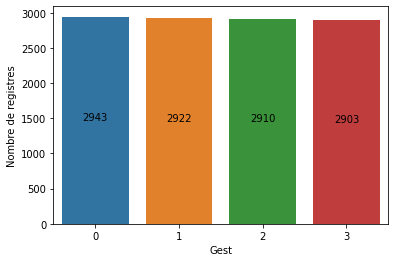

In [8]:
ax = sns.barplot(x=data['gesture'].unique(), y=data['gesture'].value_counts());
plt.xlabel("Gest");
plt.ylabel("Nombre de registres");
for p in ax.patches:
            _x = p.get_x()+p.get_width()/2
            _y = p.get_y()+p.get_height()/2
            value = '{:.0f}'.format(p.get_height())
            ax.text(_x, _y, value, ha="center")

Tenim una distribució molt balancejada dels gests. 2943 registres per a la "pedra", 2922 per al "paper", 2910 per al "tisores" i 2903 per al "OK". Per tant, podem utilitzar l'accuracy per avaluar el nostre model, ja que totes les classes estan balancejades. A més, el modelo no hauria de desenvolupar 'bias' cap a cap de les classes.

In [9]:
nullValues = 0
for n in data.isna().sum():
    if n != 0: nullValues += 1
print(f'Nombre de "missing-values": {nullValues}')

Nombre de "missing-values": 0


No hi ha "missing-values" a cap lloc, cosa positiva ja que així no els hem de tractar de cpa manera.

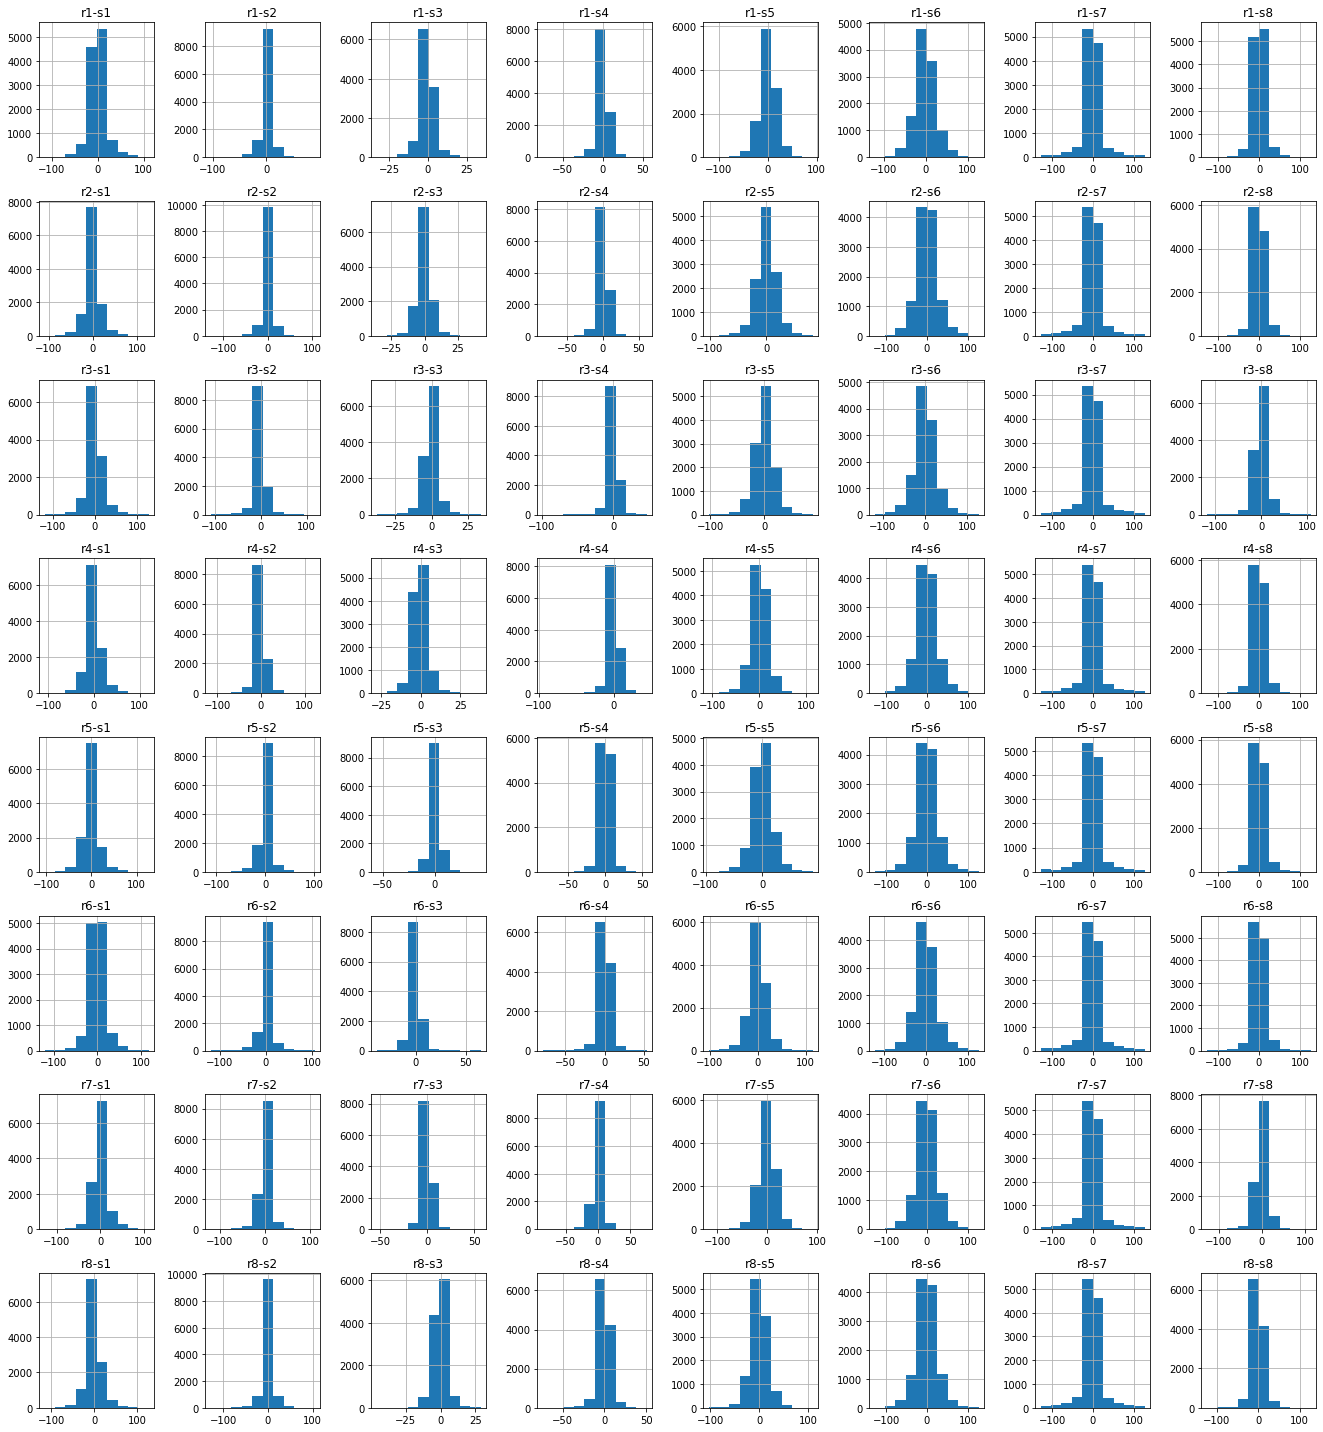

In [10]:
data.hist();
fig = plt.gcf()
fig.set_size_inches(18.5, 20)
plt.tight_layout()

Totes les lectures de tots els sensors tenen distribucions més o menys sembalnts, però pdoem observar com el rang de valors d'alguns sensors són més grans que els d'altres, per tant no està de més normalitzar aquestes dades més endevant.

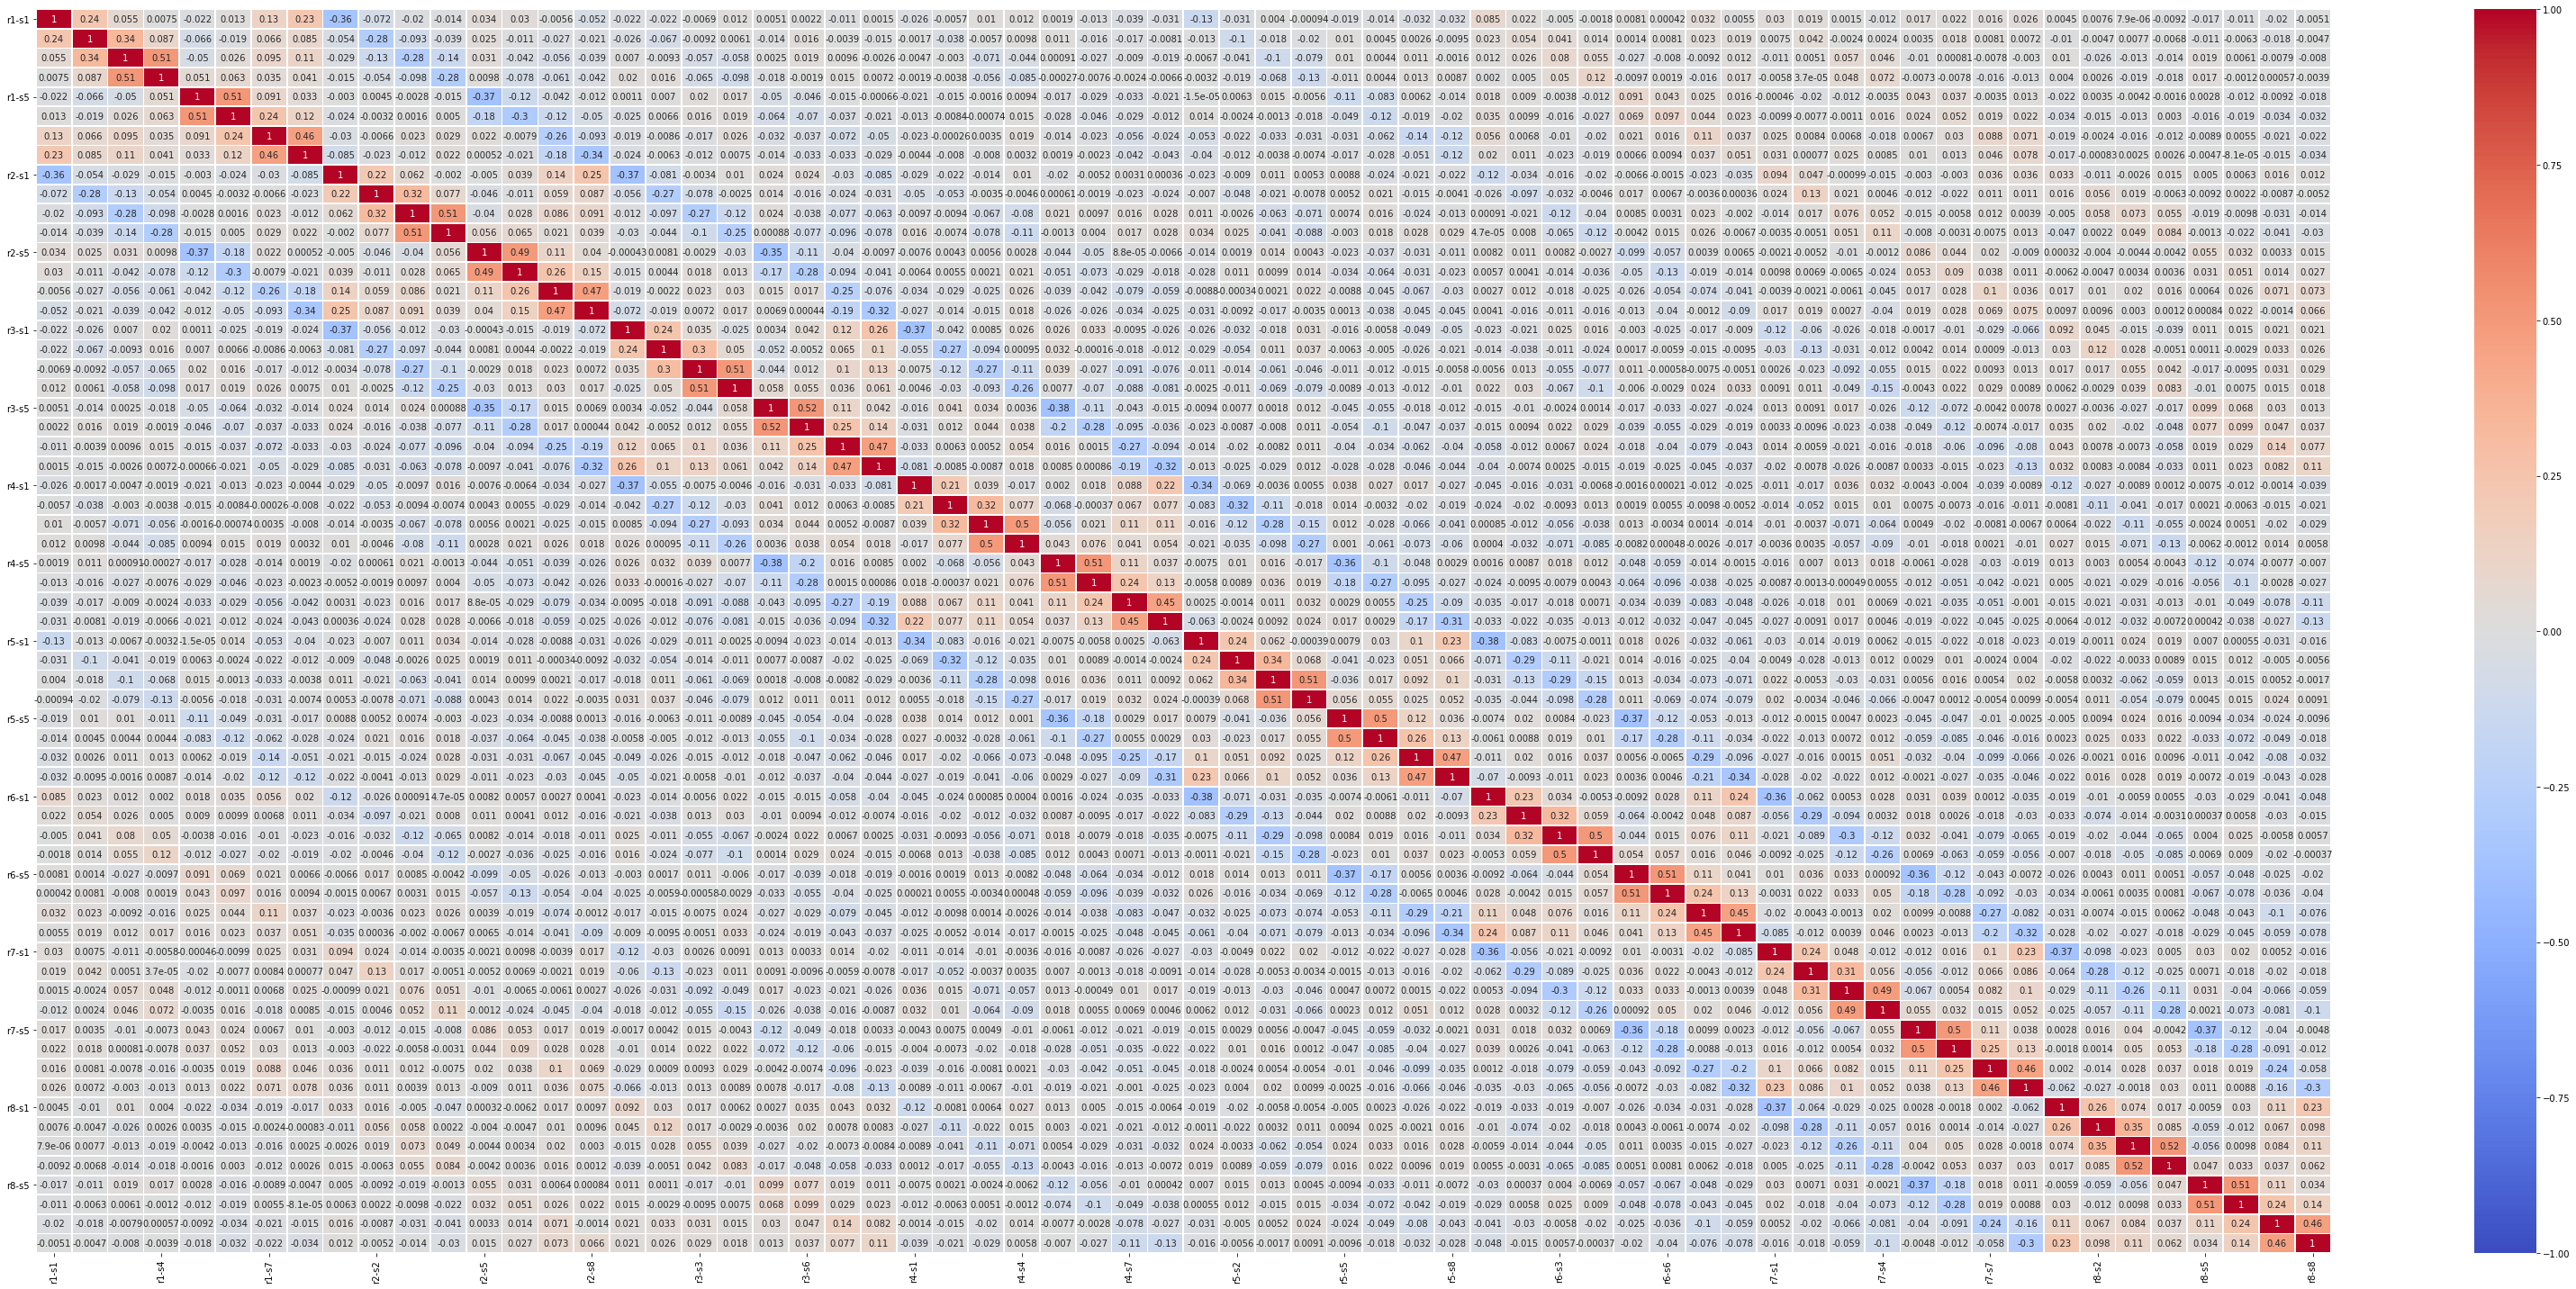

In [11]:
sns.heatmap(data.corr(), annot=True, linewidths= .75, vmin=-1, vmax=1, cmap='coolwarm');
fig = plt.gcf()
fig.set_size_inches(45, 20)
plt.tight_layout();

No observem correlacions massa destacables entre les diferents lectures. En alguns casos hi ha una lleugera correlació entre les lectures consecutives dels sensors i també s'observa una certa correlació entre les lectures dels sensors consecutius, però res que pugui afectar massa la classificació des del nostre punt de vista.

### 3. Preprocessing

Com hem dit a la secció anterior, seria recomanable normalitzar o estandarditzar les dades. Donat que com hem pogut veure totes les columnes tenen distribucions molt semblants optarem per estandarditzar les dades.

In [12]:
standarizer = StandardScaler()
data[data.columns[:-1]] = standarizer.fit_transform(data.iloc[:,:-1])

In [13]:
data.describe()

,r1-s1,r1-s2,r1-s3,r1-s4,r1-s5,r1-s6,r1-s7,r1-s8,r2-s1,r2-s2,r2-s3,r2-s4,r2-s5,r2-s6,r2-s7,r2-s8,r3-s1,r3-s2,r3-s3,r3-s4,r3-s5,r3-s6,r3-s7,r3-s8,r4-s1,r4-s2,r4-s3,r4-s4,r4-s5,r4-s6,r4-s7,r4-s8,r5-s1,r5-s2,r5-s3,r5-s4,r5-s5,r5-s6,r5-s7,r5-s8,r6-s1,r6-s2,r6-s3,r6-s4,r6-s5,r6-s6,r6-s7,r6-s8,r7-s1,r7-s2,r7-s3,r7-s4,r7-s5,r7-s6,r7-s7,r7-s8,r8-s1,r8-s2,r8-s3,r8-s4,r8-s5,r8-s6,r8-s7,r8-s8
count,11678.000,11678.000,11678.000,11678.000,11678.000,11678.000,11678.000,11678.000,11678.000,11678.000,11678.000,11678.000,11678.000,11678.000,11678.000,11678.000,11678.000,11678.000,11678.000,11678.000,11678.000,11678.000,11678.000,11678.000,11678.000,11678.000,11678.000,11678.000,11678.000,11678.000,11678.000,11678.000,11678.000,11678.000,11678.000,11678.000,11678.000,11678.000,11678.000,11678.000,11678.000,11678.000,11678.000,11678.000,11678.000,11678.000,11678.000,11678.000,11678.000,11678.000,11678.000,11678.000,11678.000,11678.000,11678.000,11678.000,11678.000,11678.000,11678.000,11678.000,11678.000,11678.000,11678.000,11678.000
mean,-0.000,-0.000,-0.000,0.000,-0.000,0.000,-0.000,0.000,-0.000,0.000,0.000,-0.000,-0.000,-0.000,-0.000,0.000,0.000,-0.000,-0.000,-0.000,0.000,-0.000,-0.000,0.000,0.000,0.000,-0.000,-0.000,-0.000,-0.000,-0.000,0.000,0.000,-0.000,0.000,-0.000,-0.000,-0.000,-0.000,0.000,-0.000,0.000,-0.000,-0.000,-0.000,-0.000,0.000,-0.000,-0.000,-0.000,-0.000,0.000,-0.000,0.000,-0.000,0.000,0.000,-0.000,-0.000,-0.000,-0.000,0.000,-0.000,-0.000
std,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000,1.000
min,-6.220,-8.777,-6.465,-9.981,-6.770,-4.706,-5.051,-8.264,-6.033,-10.755,-7.049,-11.289,-5.686,-4.920,-5.046,-8.266,-6.500,-9.089,-7.434,-13.296,-5.730,-4.662,-5.082,-7.826,-6.072,-9.555,-5.497,-12.893,-5.968,-4.884,-4.989,-8.220,-5.820,-9.157,-11.016,-11.503,-5.299,-4.851,-5.048,-8.260,-6.596,-9.807,-7.688,-10.667,-5.631,-4.682,-5.093,-8.212,-6.999,-9.966,-10.812,-11.583,-6.575,-4.922,-4.997,-8.383,-6.326,-10.601,-9.102,-9.926,-5.765,-4.995,-5.010,-7.946
25%,-0.457,-0.278,-0.453,-0.439,-0.551,-0.560,-0.188,-0.476,-0.460,-0.283,-0.455,-0.444,-0.563,-0.532,-0.186,-0.466,-0.452,-0.282,-0.448,-0.442,-0.557,-0.537,-0.190,-0.493,-0.475,-0.274,-0.456,-0.454,-0.548,-0.558,-0.183,-0.464,-0.457,-0.266,-0.444,-0.456,-0.555,-0.562,-0.181,-0.467,-0.450,-0.260,-0.445,-0.456,-0.544,-0.554,-0.184,-0.472,-0.461,-0.266,-0.447,-0.445,-0.558,-0.564,-0.173,-0.466,-0.448,-0.272,-0.449,-0.446,-0.552,-0.533,-0.180,-0.476
50%,-0.026,-0.023,-0.052,-0.036,0.009,-0.017,0.011,-0.022,-0.018,-0.029,-0.056,-0.037,-0.006,0.006,0.013,-0.011,-0.012,-0.030,-0.048,-0.036,-0.001,-0.031,0.010,-0.027,-0.022,-0.024,-0.052,-0.044,0.005,-0.022,0.014,-0.011,-0.005,-0.019,-0.045,-0.047,0.003,-0.030,0.018,-0.013,-0.011,-0.013,-0.042,-0.048,0.009,-0.019,0.017,-0.021,-0.021,-0.015,-0.041,-0.038,0.004,-0.024,0.025,-0.004,-0.009,-0.022,-0.047,-0.040,0.008,-0.024,0.018,-0.025
75%,0.405,0.317,0.549,0.501,0.569,0.525,0.210,0.432,0.368,0.309,0.544,0.505,0.551,0.545,0.212,0.379,0.373,0.306,0.551,0.505,0.555,0.514,0.211,0.440,0.374,0.311,0.552,0.503,0.558,0.514,0.211,0.441,0.390,0.310,0.553,0.498,0.561,0.539,0.217,0.442,0.373,0.316,0.561,0.496,0.562,0.516,0.178,0.431,0.363,0.319,0.569,0.506,0.566,0.554,0.183,0.457,0.376,0.312,0.557,0.502,0.569,0.523,0.176,0.426
max,6.007,7.711,6.962,7.489,5.163,4.942,5.113,8.220,7.044,9.007,8.536,8.368,4.615,4.894,5.111,8.310,7.026,9.952,6.938,6.458,5.005,4.950,5.143,7.240,6.820,10.344,7.812,6.107,6.310,4.878,5.056,8.262,7.221,8.460,8.931,7.727,5.025,4.828,5.124,8.300,6.519,8.793,13.237,7.439,6.367,4.873,5.168,8.235,6.187,9.350,11.747,10.421,5.177,4.912,5.086,7.582,7.023,8.808,5.990,7.002,6.174,4.985,5.085,8.217


Com hem vist abans, no hi ha 'missing-values', per tant no cal tractar-los. Respecte a les dades categòriques només tenim la columna 'gesture' que és, de fet, el que volem predir, per tant, tampoc hem de tractar-ho. El que sí que tenim és una quantitat raonablement gran de 64 atributs d'entrada que potser podríem intentar reduir. Tanmateix, hem pogut comprovar anteriorment que no hi ha correlacions massa fortes per tant no obtindríem millores considerables per aplicar un PCA.

### 4. Selecció de model

En aquesta secció provarem el rendiment de diferents models i hiperparàmetres per a cada model amb la intenció d'escollir un com el que considerem el millor per posteriorment fer 'cross-validation'.
Entrenarem i avaluarem els següents models:  
- Regressió logística: És potser el classificador més bàsic. Encara que normalment s'utilitza per classificació binària, però entrenant una corba per a cada classe fent un "one vs all" podem obtenir un classificador multicategoría. No esperem obtenir massa bons resultats amb aquest model, però ens servirà per poder comparar.
- SVM: Les SVM són conegudes per tenir un molt bon rendiment en classificació. Sobretot quan la dimensionalitat és alta acostumen a tenir una millor generalització que la resta de models. A més podem provar amb diferents kernels que faran variar els resultats. Els kernels que probarem són:  
    - Lineal
    - Polinomial
    - Base radial
- Random forest: Els "random forests", com sabem, són un ensemble sobre els "decision trees". Gràcies a l'algoritme C4.5 podem utilitzar "decision trees" per fer classificacions que comprenguin valors continus com en el nostre cas. A més gràcies als "random forest" que utilitzen "bagging" podem obtenir un model molt bo format per models senzills, obtenint un bon rendiment a un baix cost computacional. Creiem que poden donar molt bons resultats si resulta que uns els diferents gestos acostumen a tenir sempre unes lectures semblants (que seria lògic).
- KNN: Provarem també amb l'algorisme de KNN, que és molt bàsic, però pot arribar a donar bons resultats en aquest dataset si es compleix que cada gest acostuma a tenir unes seqüències de lectures ben definides i diferenciades entre cada un dels gestos.

En aquest primer experiment, no tunejarem els hiperparàmetres dels models, ja que disposem de molts models i serien massa paràmetres per tunejar. En canvi, avaluarem els models tal com els fa disponibles per defecte sklearn amb la finalitat de trobar 1 o 2 prometedors que estudiarem amb profunditat al cross-validation a la següent secció.

#### Entrenament dels models:

In [14]:
train_x, test_x, train_y, test_y = train_test_split(data.iloc[:,:-1], data.iloc[:,-1], test_size=0.33, random_state=42)

models = ['RegLog', 'SVMLin', 'SVMPol', 'SVMRad', 'RandFor', 'KNN']
metrics = ['Accuracy', 'AvgPrecision', 'AvgRecall', 'TrainingTime']
results = np.zeros((len(models), len(metrics)))

Fem una partició del 33% per a test i la resta per a train. Com hem utilitzat la funció "tarin_test_split" de sklearn, ens assegurem que les dades estan barrejades adequadament i, per tant, tot seguirà balancejat com havíem vist al principi. De totes maneres farem uns plots senzills per assegurar-nos que és així.
Per una altra banda preparem un array de numpy on desarem els resultats dels models que entrenarem a continuació per poder comparar-los al final i decidir amb quins ens quedem.

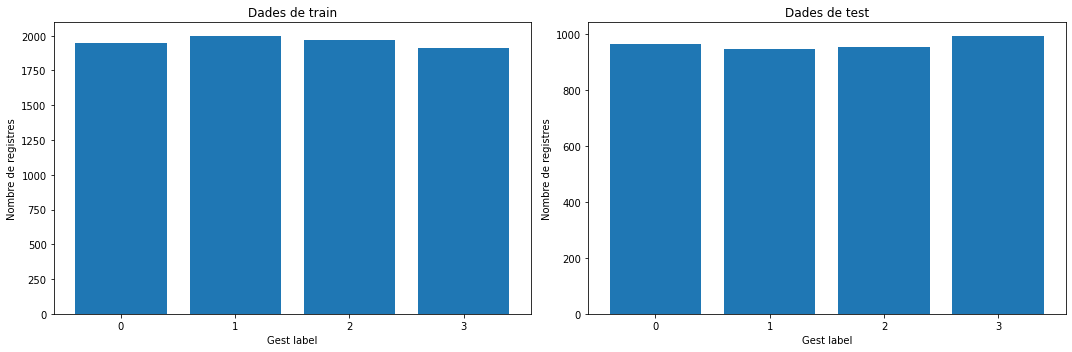

In [15]:
fig, (ax1, ax2) = plt.subplots(1,2)
for ax in [ax1, ax2]:
  if ax == ax1:
    ax.bar(train_y.unique(), train_y.value_counts());
    ax.set_title("Dades de train")
  else:
    ax.bar(test_y.unique(), test_y.value_counts());
    ax.set_title("Dades de test")
  ax.set_xticks([0,1,2,3])
  ax.set_xlabel("Gest label")
  ax.set_ylabel("Nombre de registres")
fig.set_size_inches(15, 5)
plt.tight_layout();

Efectivament tant les dades de test com les de train estan balancejades.

- Regressió Logística:

In [16]:
t = time.time()
lr = LogisticRegression().fit(train_x, train_y.astype('int'))
predictions = lr.predict(test_x)
print(classification_report(test_y.astype('int'), predictions.astype('int')))
report = classification_report(test_y.astype('int'), predictions.astype('int'), output_dict=True)
res = np.array([report['accuracy'], report['macro avg']['precision'], report['macro avg']['recall'], time.time() - t])
results[0] = res

              precision    recall  f1-score   support

           0       0.50      0.47      0.48       963
           1       0.35      0.28      0.31       991
           2       0.27      0.30      0.28       947
           3       0.30      0.35      0.32       953

    accuracy                           0.35      3854
   macro avg       0.35      0.35      0.35      3854
weighted avg       0.35      0.35      0.35      3854



- SVM Lineal:

In [17]:
t = time.time()
SVMLin = SVC(kernel="linear").fit(train_x, train_y.astype('int'))
predictions = SVMLin.predict(test_x)
print(classification_report(test_y.astype('int'), predictions.astype('int')))
report = classification_report(test_y.astype('int'), predictions.astype('int'), output_dict=True)
res = np.array([report['accuracy'], report['macro avg']['precision'], report['macro avg']['recall'], time.time() - t])
results[1] = res

              precision    recall  f1-score   support

           0       0.91      0.30      0.45       963
           1       0.32      0.39      0.35       991
           2       0.27      0.35      0.31       947
           3       0.30      0.36      0.32       953

    accuracy                           0.35      3854
   macro avg       0.45      0.35      0.36      3854
weighted avg       0.45      0.35      0.36      3854



- SVM Polinimial:

In [18]:
t = time.time()
SVMPol = SVC(kernel="poly").fit(train_x, train_y.astype('int'))
predictions = SVMPol.predict(test_x)
print(classification_report(test_y.astype('int'), predictions.astype('int')))
report = classification_report(test_y.astype('int'), predictions.astype('int'), output_dict=True)
res = np.array([report['accuracy'], report['macro avg']['precision'], report['macro avg']['recall'], time.time() - t])
results[2] = res

              precision    recall  f1-score   support

           0       0.92      0.34      0.50       963
           1       0.48      0.53      0.50       991
           2       0.75      0.18      0.29       947
           3       0.33      0.76      0.46       953

    accuracy                           0.45      3854
   macro avg       0.62      0.45      0.44      3854
weighted avg       0.62      0.45      0.44      3854



- SVM amb base radial:

In [19]:
t = time.time()
SVMRad = SVC(kernel="rbf").fit(train_x, train_y.astype('int'))
predictions = SVMRad.predict(test_x)
print(classification_report(test_y.astype('int'), predictions.astype('int')))
report = classification_report(test_y.astype('int'), predictions.astype('int'), output_dict=True)
res = np.array([report['accuracy'], report['macro avg']['precision'], report['macro avg']['recall'], time.time() - t])
results[3] = res

              precision    recall  f1-score   support

           0       0.92      0.91      0.91       963
           1       0.87      0.98      0.92       991
           2       0.93      0.84      0.88       947
           3       0.85      0.84      0.84       953

    accuracy                           0.89      3854
   macro avg       0.89      0.89      0.89      3854
weighted avg       0.89      0.89      0.89      3854



- Random Forest:

In [20]:
t = time.time()
rf = RandomForestClassifier().fit(train_x, train_y.astype('int'))
predictions = rf.predict(test_x)
print(classification_report(test_y.astype('int'), predictions.astype('int')))
report = classification_report(test_y.astype('int'), predictions.astype('int'), output_dict=True)
res = np.array([report['accuracy'], report['macro avg']['precision'], report['macro avg']['recall'], time.time() - t])
results[4] = res

              precision    recall  f1-score   support

           0       0.92      0.97      0.94       963
           1       0.96      0.90      0.93       991
           2       0.90      0.95      0.93       947
           3       0.88      0.84      0.86       953

    accuracy                           0.91      3854
   macro avg       0.91      0.91      0.91      3854
weighted avg       0.91      0.91      0.91      3854



- KNN:

In [21]:
t = time.time()
knn = RandomForestClassifier().fit(train_x, train_y.astype('int'))
predictions = knn.predict(test_x)
print(classification_report(test_y.astype('int'), predictions.astype('int')))
report = classification_report(test_y.astype('int'), predictions.astype('int'), output_dict=True)
res = np.array([report['accuracy'], report['macro avg']['precision'], report['macro avg']['recall'], time.time() - t])
results[5] = res

              precision    recall  f1-score   support

           0       0.93      0.97      0.95       963
           1       0.95      0.90      0.92       991
           2       0.90      0.96      0.93       947
           3       0.87      0.84      0.86       953

    accuracy                           0.92      3854
   macro avg       0.92      0.92      0.92      3854
weighted avg       0.92      0.92      0.92      3854



Una vegada entrenats i testejats tots els models sense tunejar, observem i comparem de manera gràfica els seus resultats per a escollir aquells més prometedors sobre els que farem "fine tuning" per intentar obtenir els millors resulats prossibles i sobre els que farem "cross-validation" per assegurar-nos de que els resultats obtinguts no han sigut obtinguts per a sort d'ahver escollit unes dades d'entrenament i test determinades.

In [71]:
results_df

,Accuracy,AvgPrecision,AvgRecall,TrainingTime
RegLog,0.347,0.353,0.347,0.209
SVMLin,0.349,0.452,0.348,26.225
SVMPol,0.452,0.622,0.451,11.324
SVMRad,0.891,0.892,0.890,8.751
RandFor,0.915,0.915,0.915,4.607
KNN,0.916,0.916,0.917,4.571


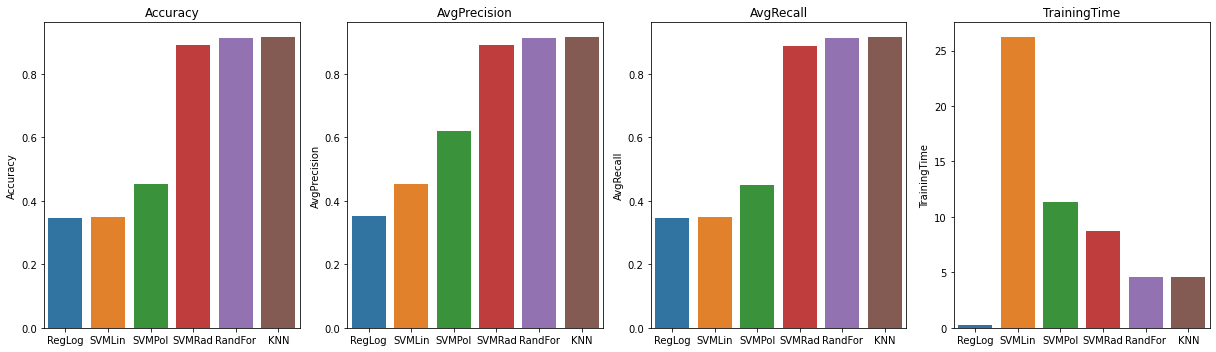

In [72]:
results_df = pd.DataFrame(data = results, columns = metrics, index = models)
fig = plt.figure()
for i in range(1,5):
  ax = fig.add_subplot(1,4,i)
  ax.set_title(metrics[i-1])
  sns.barplot(ax = ax, data=results_df, x=models, y=metrics[i-1]);
fig.set_size_inches(17, 5)
plt.tight_layout();

Podem observar com tant el model de regressió logística, la màquina de vectors de suport amb kernel lineal i la que utilitza kernel polinomial no han sigut capaços d'adaptarse a les dades. A més, les dues màquines de vectors de suports ara mencionades són els models que me triguen en executar el seu entrenament. No passa el mateix amb la regressió logística, que es el model que requereix menys temps per ser entrenat, però evidentment no val la pena utilitzar aquest model degut als seus resultats.  
Per una altra banda, tenim els models de la màquina de vector de suport amb kernel radial, el random forest i el KNN. Aquests han sigut els models que han aconseguit les 3 millors puntuacions tant en "accuracy" com en la mitja de "precision" i "recall". SIGUE POR AQUÍ!!!